# SF2935 Project

This is a low-data event, namely we are gven 500 training samples. The dataset comprises of songs, and each row is sample song, which is represented by a an 11-D Vector which account for 11 features - !!!TODO Write them here

In [2]:
import random

import pandas as pd

import numpy as np 

import matplotlib.pyplot as plt

import scipy.linalg as la
from scipy.stats import mode

import seaborn as sns

from bayes_opt import BayesianOptimization

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

seed = 42

## TODO

- __Pre-processing__
    - [ ] Relevance determination of features
    - [ ] Visualize dataset
    - [ ] Split into training and test sets
    
- __Models__
    - [ ] Logistic regression
    - [ ] Discriminant analysis (LDA, QDA)
    - [ ] k-Nearest neighbours
    - [ ] Support vector machines
    - [ ] Tree based methods 
    - [ ] Neural networks

- __Model validation and tuning__
    - [ ] k-Cross validation
    - [ ] Confusion matrix analysis
    - [ ] Bayesian optimization of hyper-parameters
    - [ ] Relevance determination

- __Extras__
    - [ ] Used GAN to generate data to improve neural network classification

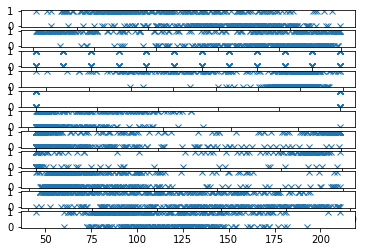

In [3]:
dataset  = np.genfromtxt('project_train.csv', delimiter=',')
dataset  = dataset[~np.isnan(dataset).any(axis=1)]

features = ['danceability', 'energy','key','loudness','mode','speechniess','acousticness','instrumentalness','liveness','valence','tempo']

# x,y of whole dataset
x = dataset[:,0:-1]
y = dataset[:,-1]


loudness_outlier1_ind = np.argmax(x[:,3]) # feature number 4 in list
x = np.delete(x, loudness_outlier1_ind, 0)
y = np.delete(y, loudness_outlier1_ind, 0)

loudness_outlier2_ind = np.argmin(x[:,3]) # feature number 4 in list
x = np.delete(x, loudness_outlier2_ind, 0)
y = np.delete(y, loudness_outlier2_ind, 0)

energy_outlier_ind    = np.argmax(x[:,1]) # feature number 2 in list
x = np.delete(x, energy_outlier_ind, 0)
y = np.delete(y, energy_outlier_ind, 0)



test_set_final = np.genfromtxt('project_test.csv', delimiter=',')
test_set_final  = test_set_final[~np.isnan(test_set_final).any(axis=1)]
x_all_tree = np.delete(x, 2, axis=1)
x_all_cont = np.delete(x,(2,4),axis=1)

test_set_final_tree  = np.delete(test_set_final, 2, axis=1)
test_set_final_cont  = np.delete(test_set_final, (2,4), axis=1)

fig, axs = plt.subplots(len(features))
for i in range(len(features)):
    axs[i].plot(x[:,i],y,'x')
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi']     = 100 

#No. datapoints from each class.
nClass0 = sum(y==0)
nClass1 = sum(y==1)

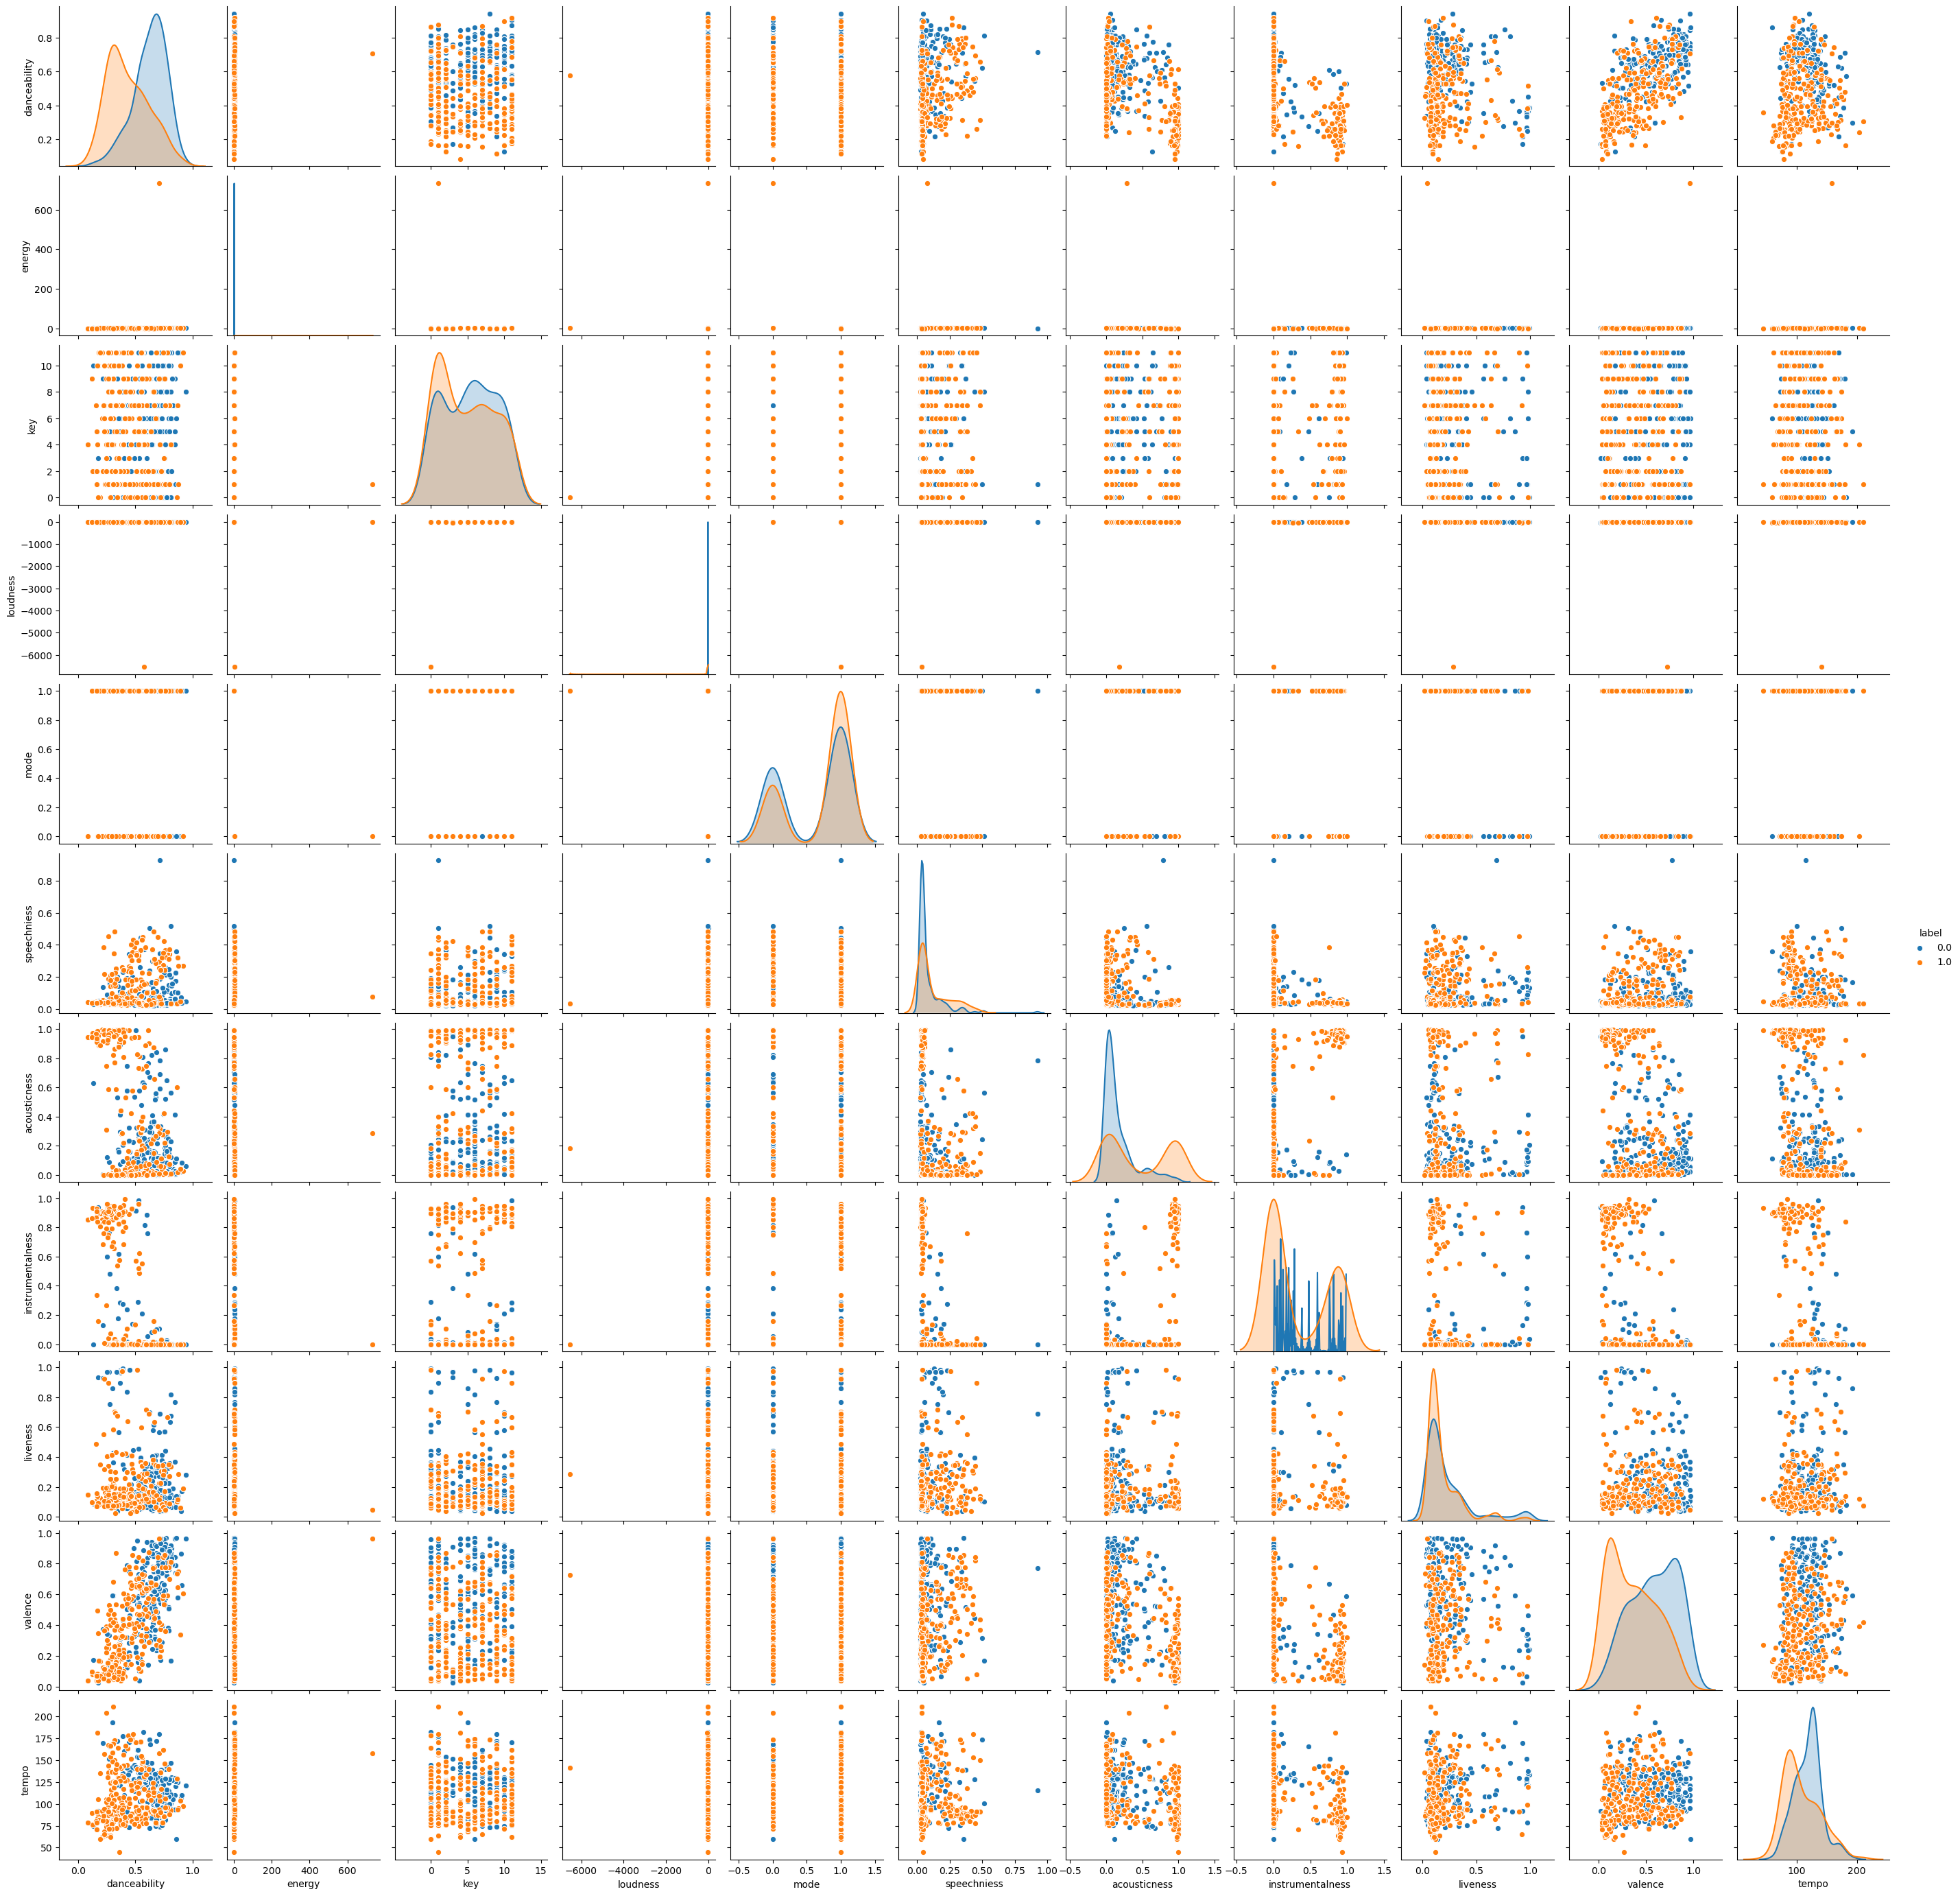

In [17]:
# Scatter plot matrix of data

df = pd.DataFrame(dataset)
df.columns = features + ["label"]

scatter_plot=sns.pairplot(df,hue="label")

scatter_plot.savefig("scatter_plot.png")

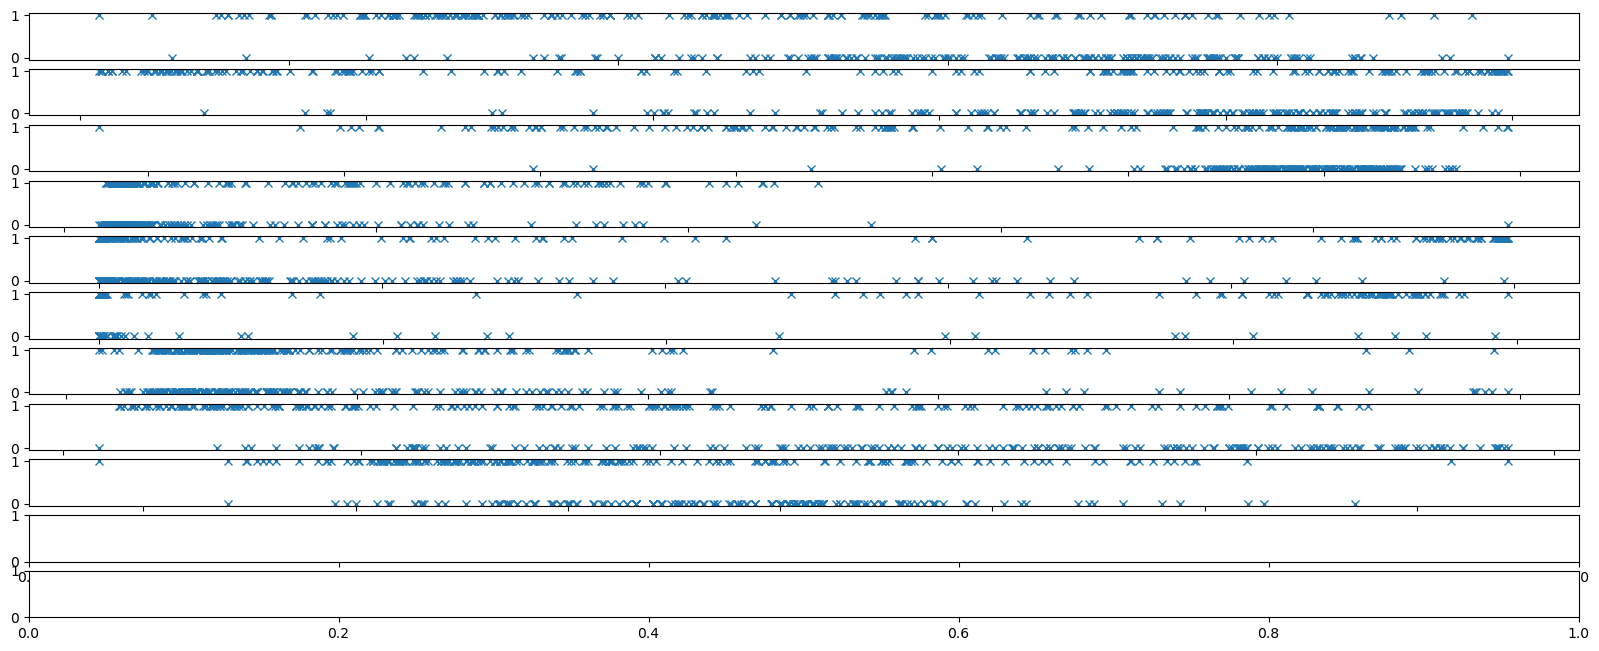

In [4]:
# Scaling the input features, then splitting into training and testing dataset
scaler   = StandardScaler()
scaler.fit(x)
dataset  = scaler.transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=seed)

x_train_cont = np.delete(x_train, (2,4), axis=1)

x_test_cont = np.delete(x_test, (2,4), axis=1)

x_train_tree = np.delete(x_train, 2, axis=1)
x_test_tree  = np.delete(x_test, 2, axis=1)


fig, axs = plt.subplots(len(features))
for i in range(len(features)-2):
    axs[i].plot(x_train_cont[:,i],y_train,'x')
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi']     = 100 

In [11]:
# PCA Analysis

pca_scaler   = StandardScaler()
pca_scaler.fit(x_all_tree)
pca_dataset  = pca_scaler.transform(x_all_tree)

df_pca = pd.DataFrame(pca_dataset)
features_minus_key  = ['danceability', 'energy','loudness','mode','speechniess','acousticness','instrumentalness','liveness','valence','tempo']
df_pca.columns = features_minus_key

pca =PCA()
pca.fit(df_pca)
pca_data = pca.transform(df_pca)

In [ ]:
# FIS THIS
# PCA Analysis

pca_scaler   = StandardScaler()
pca_scaler.fit(np.concatenate((x_all_tree, test_set_final_tree),axis=0))
pca_dataset  = pca_scaler.transform(np.concatenate((x_all_tree, test_set_final_tree),axis=0))

df_pca = pd.DataFrame(pca_dataset)
features_minus_key  = ['danceability', 'energy','loudness','mode','speechniess','acousticness','instrumentalness','liveness','valence','tempo']
df_pca.columns = features_minus_key

#df_pca.insert(10, "label", y, True)

pca =PCA()
pca.fit(df_pca)
pca_data = pca.transform(df_pca)
df_pca_visual = pd.DataFrame(pca_data)
df_pca_visual.columns = features_minus_key
df_pca_visual.insert(10, "label", np.array([item for sublist in [list(y),random.sample(range(1, 1000), 80)] for item in sublist]), True)

pca_all_np = df_pca_visual.to_numpy()
x_all_tree_pca = pca_all_np[:480,0:10]
x_test_final_pca = pca_all_np[480:,0:10]

x_train_tree_pca, x_test_tree_pca, y_train_tree_pca, y_test_tree_pca = train_test_split(x_all_tree_pca, y, test_size=0.20, random_state=seed)

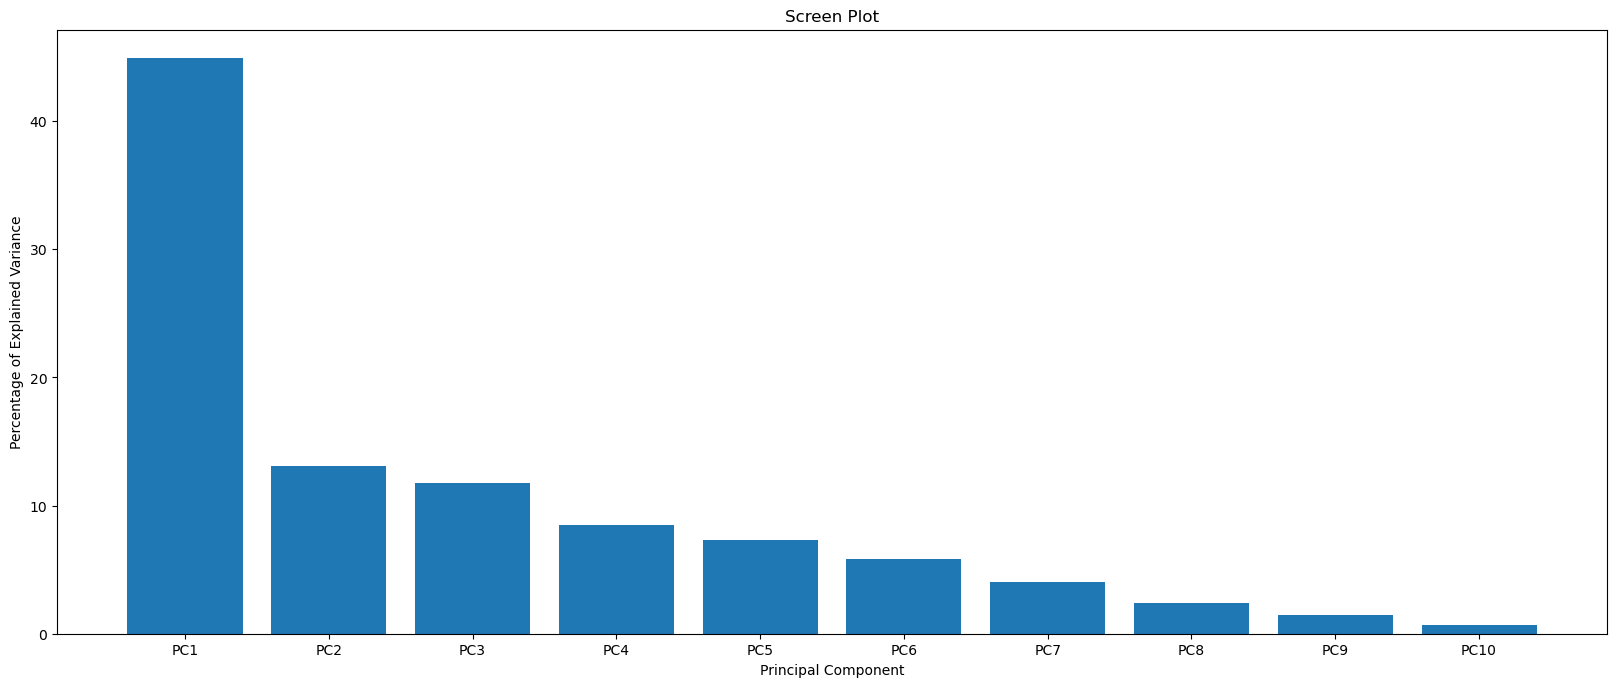

In [9]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ["PC"+str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Screen Plot')
plt.show()

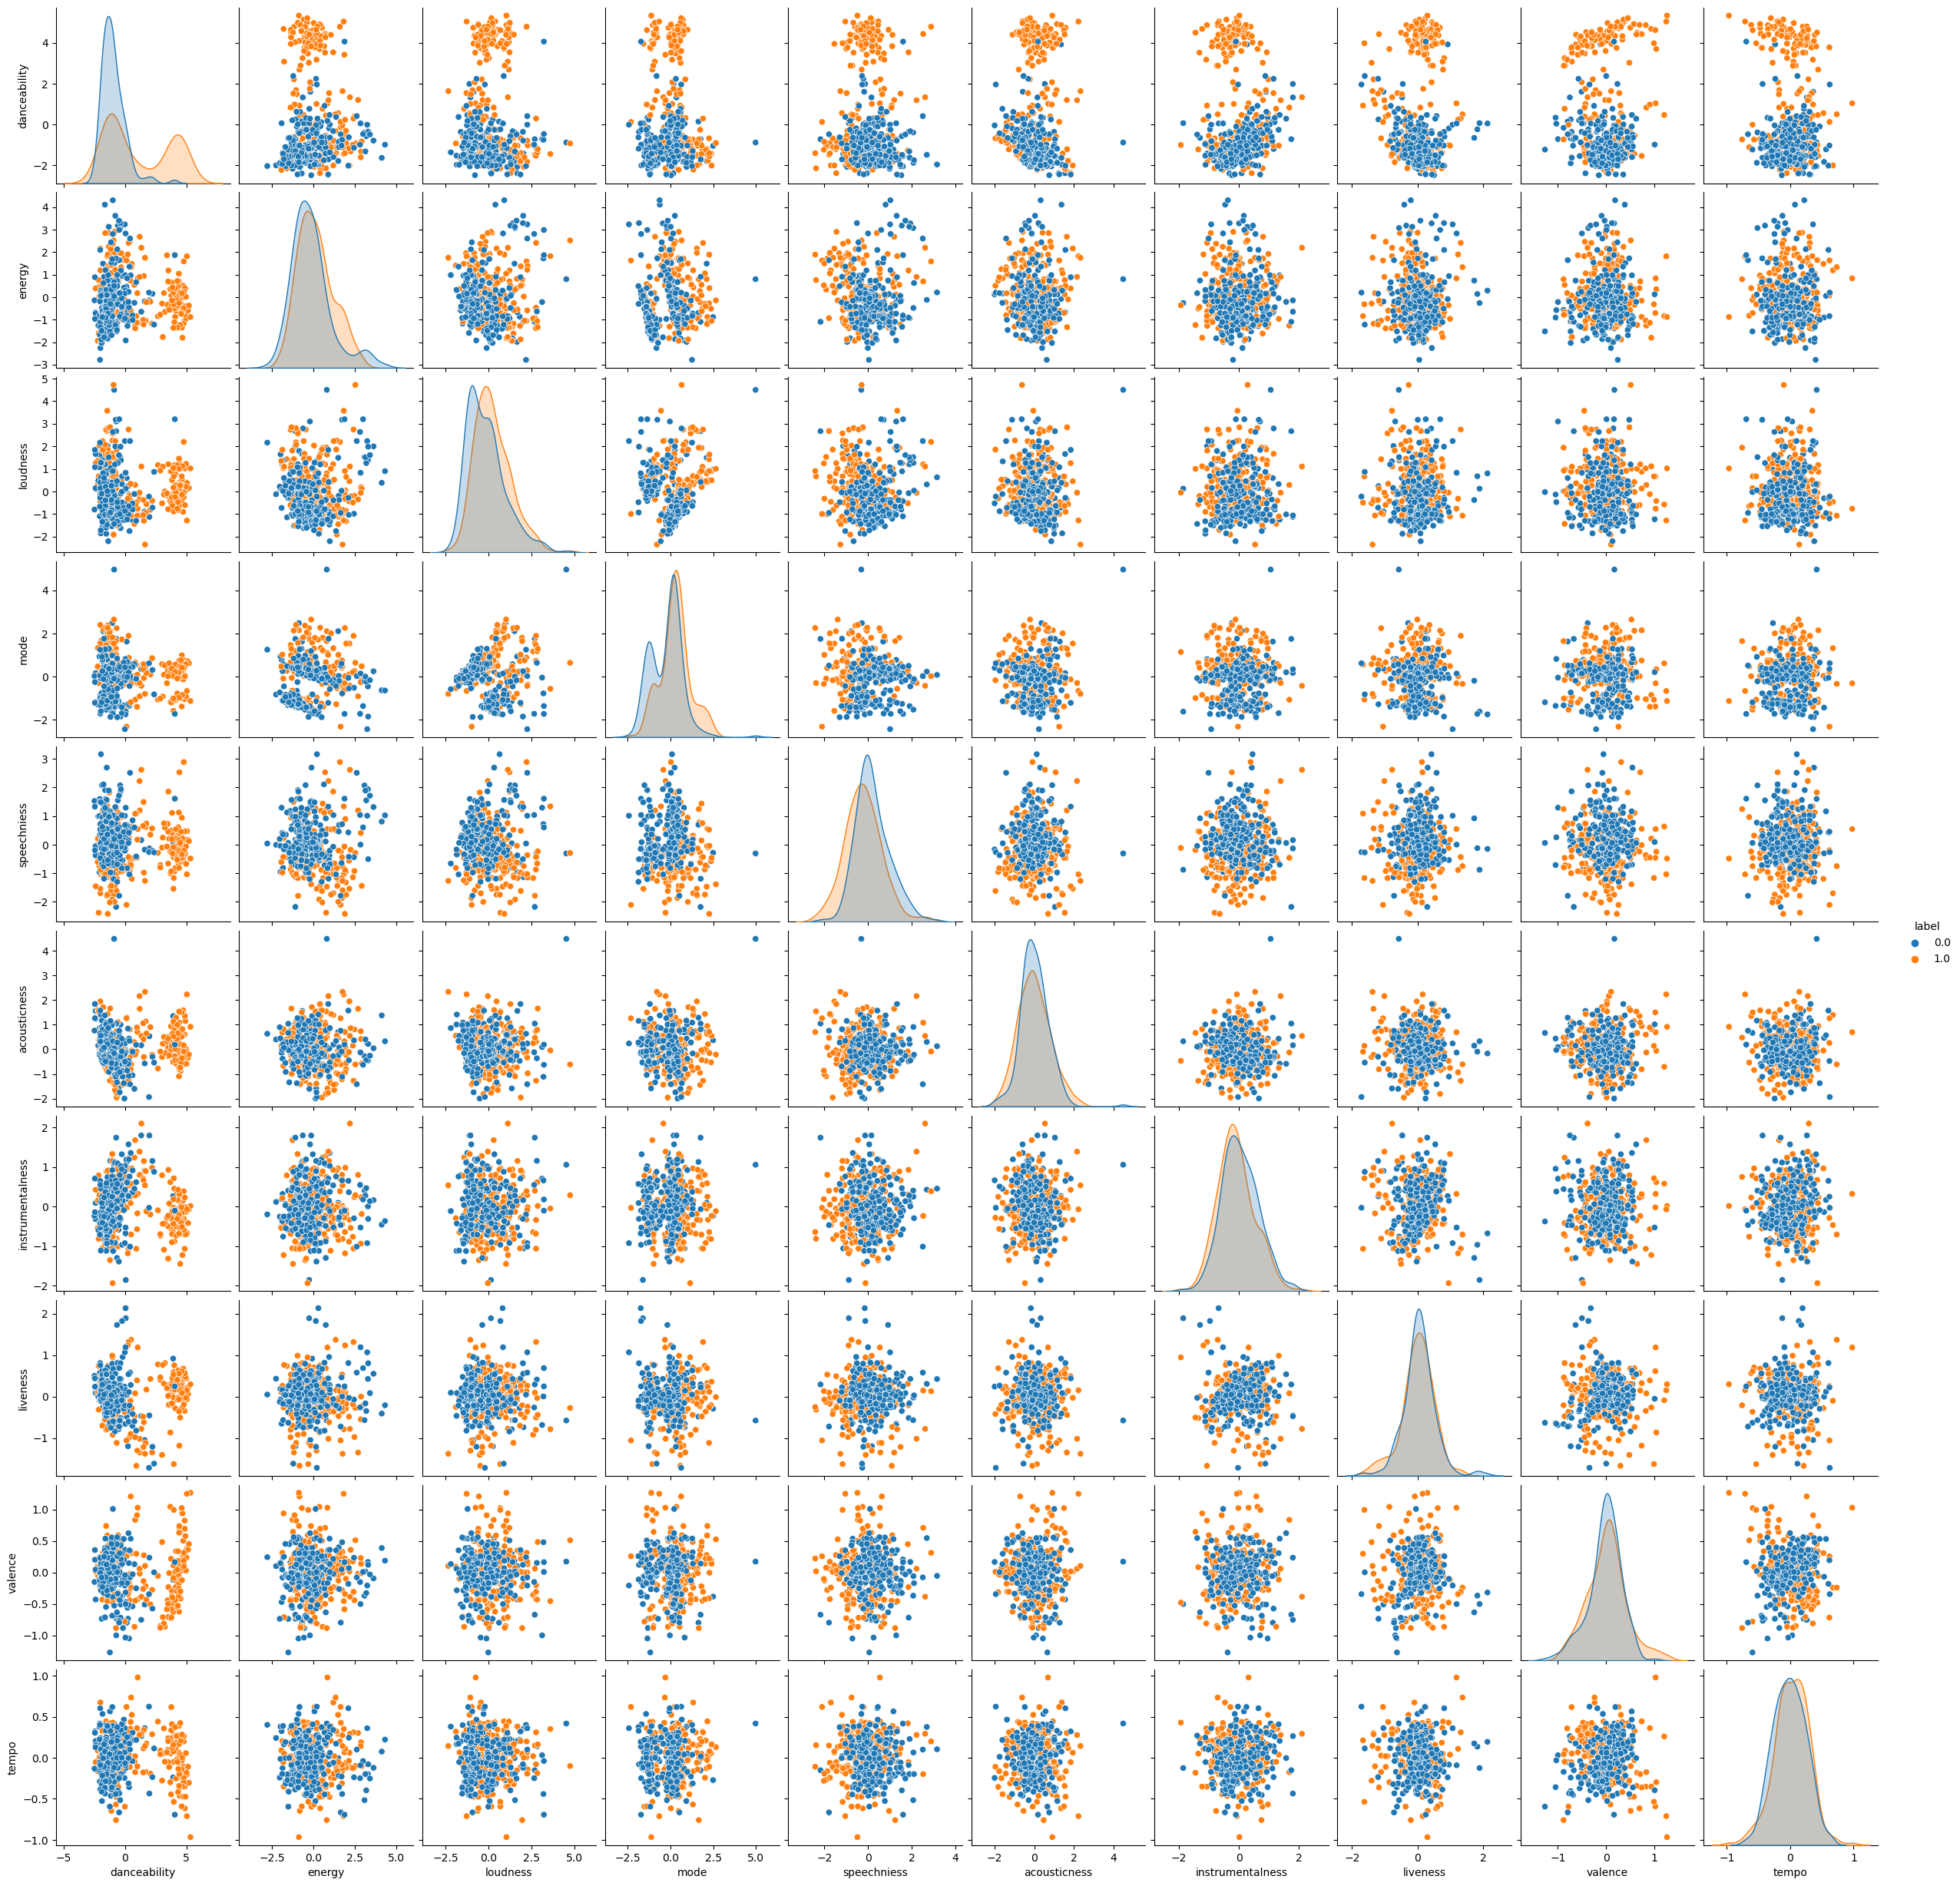

In [19]:
# Scatter plot matrix of data
pca_data_visual = pd.DataFrame(pca_data)
pca_data_visual.insert(10, "label", y, True)
vis=pd.DataFrame(pca_all_np[:480,:])
vis.columns = ['danceability', 'energy','loudness','mode','speechniess','acousticness','instrumentalness','liveness','valence','tempo','label']
scatter_plot=sns.pairplot(vis,hue="label")
scatter_plot.savefig("scatter_plot.png")

## Logistic regression

In [48]:
# Logistic Regression model with hyper-parameter tuning using Bayesian optimzation
def logistic_regression_for_bo(hyper_params, x, y, x_t, y_t):
    logistic_model = LogisticRegression(max_iter=500, C=hyper_params, random_state=seed)
    objective = np.min(cross_val_score(logistic_model, x, y, cv=5))
    #logistic_model.fit(x,y)
    #objective = logistic_model.score(x_t, y_t)
    return objective

optimizer = BayesianOptimization(
    f            = lambda l: logistic_regression_for_bo(l, x_train_cont, y_train, x_test_cont, y_test),
    pbounds      = {'l': (0.0001, 100)},
    random_state = seed
)

optimizer.maximize(
    init_points=25,
    n_iter=25
)

optimizer.max

|   iter    |  target   |     l     |
-------------------------------------
|  1        |  0.7532   |  37.45    |
|  2        |  0.7532   |  95.07    |
|  3        |  0.7532   |  73.2     |
|  4        |  0.7532   |  59.87    |
|  5        |  0.7532   |  15.6     |
|  6        |  0.7532   |  15.6     |
|  7        |  0.7662   |  5.808    |
|  8        |  0.7532   |  86.62    |
|  9        |  0.7532   |  60.11    |
|  10       |  0.7532   |  70.81    |
|  11       |  0.7273   |  2.059    |
|  12       |  0.7532   |  96.99    |
|  13       |  0.7532   |  83.24    |
|  14       |  0.7532   |  21.23    |
|  15       |  0.7532   |  18.18    |
|  16       |  0.7532   |  18.34    |
|  17       |  0.7532   |  30.42    |
|  18       |  0.7532   |  52.48    |
|  19       |  0.7532   |  43.19    |
|  20       |  0.7532   |  29.12    |
|  21       |  0.7532   |  61.19    |
|  22       |  0.7532   |  13.95    |
|  23       |  0.7532   |  29.21    |
|  24       |  0.7532   |  36.64    |
|  25       

{'target': 0.7662337662337663, 'params': {'l': 5.8084554084587285}}

In [52]:
logistic_model = LogisticRegression(max_iter=500, C=5.808, random_state=seed)
logistic_model.fit(x_train_cont, y_train)
logistic_model.score(x_test_cont,y_test)

0.75

## Linear Discriminant Analysis (Anton)

In [54]:
#Assumes that the proportion of probabilites is 0.5.

# On all features except key
lda_model = LinearDiscriminantAnalysis() #Creates LDA instance.
lda_model.fit(x_train,y_train) #Training
lda_score = lda_model.score(x_test, y_test) #The predictions for the test set.
print("On all features apart from key, LDA gives k-fold validation score is ",np.mean(cross_val_score(lda_model, x_all_tree, y, cv=5)))
print("On all features apart from key, LDA gives test error on random 20% subset as ",lda_score)


# On all continuous features
lda_model_cont = LinearDiscriminantAnalysis() #Creates LDA instance.
lda_model_cont.fit(x_train_cont,y_train) #Training
lda_score_cont = lda_model_cont.score(x_test_cont, y_test) #The predictions for the test set.
print("On all continuously measurable features, LDA gives k-fold validation score is ",np.mean(cross_val_score(lda_model_cont, x_all_cont, y, cv=5)))
print("On all continuously measurable features, LDA gives test error on random 20% subset as ",lda_score_cont)

On all features apart from key, LDA gives k-fold validation score is  0.7437499999999999
On all features apart from key, LDA gives test error on random 20% subset as  0.7708333333333334
On all continuously measurable features, LDA gives k-fold validation score is  0.7333333333333334
On all continuously measurable features, LDA gives test error on random 20% subset as  0.7708333333333334


## Quadratic Discriminant Analysis (Nazaal)

In [22]:
#Assumes that the proportion of probabilites is 0.5.

# On all features except key
qda_model = QuadraticDiscriminantAnalysis() #Creates QDA instance.
qda_model.fit(x_train,y_train) #Training.
qda_score = qda_model.score(x_test, y_test)
print("On all features apart from key, QDA gives k-fold validation score is ",np.mean(cross_val_score(qda_model, x_all_tree, y, cv=5)))
print("On all features apart from key, QDA gives test error on random 20% subset as ",qda_score)


# On all continuous features
qda_model_cont = QuadraticDiscriminantAnalysis() #Creates QDA instance.
qda_model_cont.fit(x_train_cont,y_train) #Training.
qda_score_cont = qda_model_cont.score(x_test_cont, y_test)
print("On all continuously measurable features, QDA gives k-fold validation score is ",np.mean(cross_val_score(qda_model_cont, x_all_cont, y, cv=5)))
print("On all continuously measurable features, QDA gives test error on random 20% subset as ",qda_score_cont)

On all features apart from key, QDA gives k-fold validation score is  0.68125
On all features apart from key, QDA gives test error on random 20% subset as  0.84375
On all continuously measurable features, QDA gives k-fold validation score is  0.6833333333333333
On all continuously measurable features, QDA gives test error on random 20% subset as  0.8333333333333334


## k-Nearest neighbours (Viktor)

Left: Fit after removing key, Right: Fit on all continuous features. Top: k-fold cross validation accuracy with k=5, Bottom: Test set accuracy on randomly chosen test set which is 20% of the data


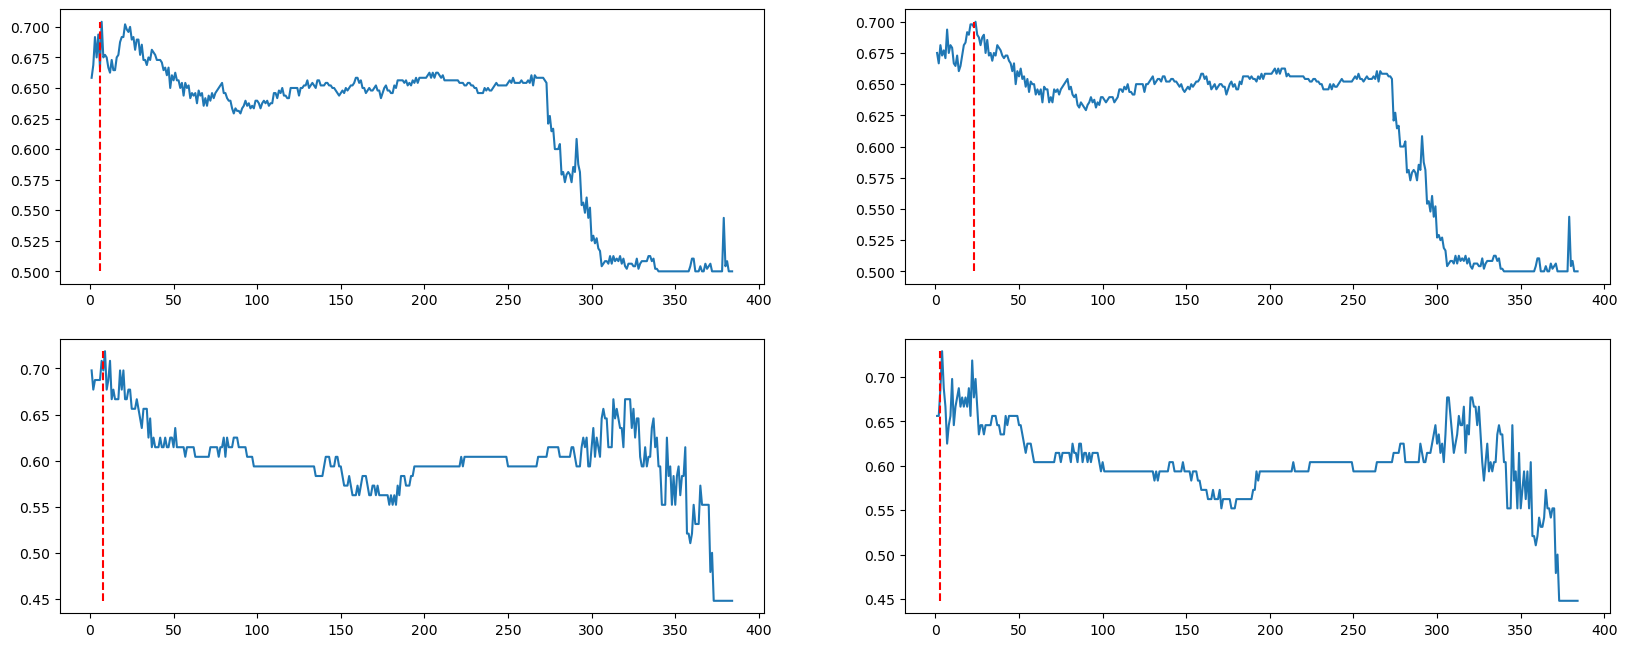

In [63]:
# k Nearest Neighbours classification for various k

kfold_acc_list = []
split_acc_list = []
for k in range(1,len(x_train)+1):
    neigh = KNeighborsClassifier(n_neighbors=k)
    kfold_acc_list.append(np.mean(cross_val_score(neigh, x_all_tree, y, cv=5)))
    neigh.fit(x_train, y_train)
    y_pred = neigh.predict(x_test)
    split_acc_list.append(metrics.accuracy_score(y_test, y_pred))

    
max_kfold_acc = max(kfold_acc_list)
max_split_acc = max(split_acc_list)
opt_neighs_kfold = kfold_acc_list.index(max_kfold_acc)
opt_neighs_split = split_acc_list.index(max_split_acc)




cont_kfold_acc_list = []
cont_split_acc_list = []
for k in range(1,len(x_train)+1):
    neigh_cont = KNeighborsClassifier(n_neighbors=k)
    cont_kfold_acc_list.append(np.mean(cross_val_score(neigh_cont, x_all_cont, y, cv=5)))
    neigh_cont.fit(x_train_cont, y_train)
    y_pred = neigh_cont.predict(x_test_cont)
    cont_split_acc_list.append(metrics.accuracy_score(y_test, y_pred))

    
cont_max_kfold_acc = max(cont_kfold_acc_list)
cont_max_split_acc = max(cont_split_acc_list)
cont_opt_neighs_kfold = cont_kfold_acc_list.index(cont_max_kfold_acc)
cont_opt_neighs_split = cont_split_acc_list.index(cont_max_split_acc)




fig, axs = plt.subplots(2,2)
axs[0,0].plot(range(1,len(x_train)+1),kfold_acc_list,[opt_neighs_kfold,opt_neighs_kfold],[min(kfold_acc_list),max_kfold_acc],'r--')
axs[1,0].plot(range(1,len(x_train)+1),split_acc_list,[opt_neighs_split,opt_neighs_split],[min(split_acc_list),max_split_acc],'r--')

axs[0,1].plot(range(1,len(x_train)+1),cont_kfold_acc_list,[cont_opt_neighs_kfold,cont_opt_neighs_kfold],[min(cont_kfold_acc_list),cont_max_kfold_acc],'r--')
axs[1,1].plot(range(1,len(x_train)+1),cont_split_acc_list,[cont_opt_neighs_split,cont_opt_neighs_split],[min(cont_split_acc_list),cont_max_split_acc],'r--')    

print("Left: Fit after removing key, Right: Fit on all continuous features. Top: k-fold cross validation accuracy with k=5, Bottom: Test set accuracy on randomly chosen test set which is 20% of the data")

## Support Vector Machines (Viktor)

In [39]:
svm_model = svm.LinearSVC(max_iter=100,)
svm_model.fit(x_train_cont,y_train)
print(svm_model.score(x_test_cont,y_test))

0.75


In [81]:
# SVM classifier on the continuous features only, with the linear kernel
def svm_trainer(hyper_params, x,y,x_t,y_t):
    svm_model = LinearSVC(C=hyper_params, max_iter=1000,dual=False)
    #svm_model.fit(x,y)
    #objective = svm_model.score(x_t,y_t)
    objective = np.min(cross_val_score(svm_model, x, y, cv=5))
    return objective

optimizer = BayesianOptimization(
    f            = lambda C: svm_trainer(C, x_train_cont, y_train, x_test_cont, y_test),
    pbounds      = {'C': (0.01, 5.0)},
    random_state = seed
)

optimizer.maximize(
    init_points=10,
    n_iter=10
)

optimizer.max

svm_model = LinearSVC(max_iter=100,C=0.1645,dual=False)
svm_model.fit(x_train_cont,y_train)
print(svm_model.score(x_test_cont,y_test))

|   iter    |  target   |     C     |
-------------------------------------
|  1        |  0.7532   |  1.879    |
|  2        |  0.7532   |  4.754    |
|  3        |  0.7532   |  3.663    |
|  4        |  0.7532   |  2.997    |
|  5        |  0.7532   |  0.7885   |
|  6        |  0.7532   |  0.7884   |
|  7        |  0.7273   |  0.2998   |
|  8        |  0.7532   |  4.332    |
|  9        |  0.7532   |  3.01     |
|  10       |  0.7532   |  3.543    |
|  11       |  0.7662   |  1.271    |
|  12       |  0.7532   |  1.465    |
|  13       |  0.7662   |  1.098    |
|  14       |  0.7532   |  2.375    |
|  15       |  0.7662   |  1.186    |
|  16       |  0.7532   |  5.0      |
|  17       |  0.7532   |  4.012    |
|  18       |  0.7662   |  0.9934   |
|  19       |  0.7532   |  2.654    |
|  20       |  0.7662   |  1.04     |
0.75


In [82]:
svm_model = LinearSVC(max_iter=100,C=2.5,dual=False)
svm_model.fit(x_train_cont,y_train)
print(svm_model.score(x_test_cont,y_test))

0.7708333333333334


In [86]:
# SVM classifier on the continuous features only, with RBF kernel

def svm_trainer(kernel, hyper_params, x,y,x_t,y_t):
    svm_model = svm.SVC(kernel=kernel, C=hyper_params[0], gamma=hyper_params[1])
    #svm_model.fit(x,y)
    #objective = svm_model.score(x_t,y_t)
    objective = np.min(cross_val_score(svm_model, x, y, cv=5)) 
    return objective


optimizer = BayesianOptimization(
    f            = lambda C, gamma: svm_trainer("rbf", [np.exp(C), np.exp(gamma)], x_train_cont, y_train, x_test_cont, y_test),
    pbounds      = {'C': (0.0001, 5.0), 'gamma': (0.0001, 5.0)},
    random_state = seed
)

optimizer.maximize(
    init_points=15,
    n_iter=15
)

optimizer.max

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
|  1        |  0.5195   |  1.873    |  4.754    |
|  2        |  0.5455   |  3.66     |  2.993    |
|  3        |  0.6234   |  0.7802   |  0.7801   |
|  4        |  0.5195   |  0.2905   |  4.331    |
|  5        |  0.5325   |  3.006    |  3.54     |
|  6        |  0.5195   |  0.103    |  4.85     |
|  7        |  0.6234   |  4.162    |  1.062    |
|  8        |  0.6104   |  0.9092   |  0.9171   |
|  9        |  0.5584   |  1.521    |  2.624    |
|  10       |  0.5974   |  2.16     |  1.456    |
|  11       |  0.6234   |  3.059    |  0.6976   |
|  12       |  0.5714   |  1.461    |  1.832    |
|  13       |  0.5325   |  2.28     |  3.926    |
|  14       |  0.5714   |  0.9984   |  2.571    |
|  15       |  0.6753   |  2.962    |  0.2323   |
|  16       |  0.6883   |  2.04     |  0.0001   |
|  17       |  0.6883   |  5.0      |  0.0001   |
|  18       |  0.6883   |  4.03     |  0.0001   |


{'target': 0.6883116883116883,
 'params': {'C': 2.040282148857932, 'gamma': 0.0001}}

## Tree based methods (Anton)

In [14]:
# Normal decision tree
def dec_tree_trainer(hyper_params, x,y,x_t,y_t):
    dec_tree = tree.DecisionTreeClassifier(random_state=seed, max_depth=hyper_params[0], min_samples_leaf=hyper_params[1])
    objective = np.mean(cross_val_score(dec_tree, x, y, cv=5))
    return objective

optimizer = BayesianOptimization(
    f            = lambda max_depth, min_samples_leaf: dec_tree_trainer([int(max_depth), int(min_samples_leaf)], x_all_tree, y, x_test_cont, y_test),
    pbounds      = {'max_depth': (1,10), 'min_samples_leaf': (1,50)},
    random_state = seed
)

optimizer.maximize(
    init_points=15,
    n_iter=15
)

optimizer.max

#tree.plot_tree(clt)

|   iter    |  target   | max_depth | min_sa... |
-------------------------------------------------
|  1        |  0.6937   |  4.371    |  47.59    |
|  2        |  0.6687   |  7.588    |  30.33    |
|  3        |  0.6708   |  2.404    |  8.644    |
|  4        |  0.6604   |  1.523    |  43.44    |
|  5        |  0.6771   |  6.41     |  35.7     |
|  6        |  0.6604   |  1.185    |  48.53    |
|  7        |  0.7021   |  8.492    |  11.4     |
|  8        |  0.6708   |  2.636    |  9.987    |
|  9        |  0.6521   |  3.738    |  26.71    |
|  10       |  0.7292   |  4.888    |  15.27    |
|  11       |  0.7063   |  6.507    |  7.835    |
|  12       |  0.65     |  3.629    |  18.95    |
|  13       |  0.6771   |  5.105    |  39.47    |
|  14       |  0.6667   |  2.797    |  26.2     |
|  15       |  0.6958   |  6.332    |  3.276    |
|  16       |  0.7063   |  5.707    |  14.27    |
|  17       |  0.6562   |  3.873    |  14.88    |
|  18       |  0.7292   |  4.905    |  15.27    |


{'target': 0.7333333333333334,
 'params': {'max_depth': 8.807072856658229,
  'min_samples_leaf': 6.659380395130909}}

In [88]:
# Adaptive boosting

def ada_tree_trainer(hyper_params, x,y,x_t,y_t):
    ada_tree = AdaBoostClassifier(random_state=seed, n_estimators=hyper_params[0], learning_rate=hyper_params[1])
    objective = np.mean(cross_val_score(ada_tree, x, y, cv=5))
    return objective

optimizer = BayesianOptimization(
    f            = lambda n_estimators, learning_rate: ada_tree_trainer([int(n_estimators), learning_rate], x_train_tree, y_train, x_test_cont, y_test),
    pbounds      = {'n_estimators': (50,100), 'learning_rate': (0.1,5)},
    random_state = seed
)

optimizer.maximize(
    init_points=30,
    n_iter=30
)

optimizer.max

#tree.plot_tree(clt)


|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
|  1        |  0.7892   |  1.935    |  97.54    |
|  2        |  0.7056   |  3.687    |  79.93    |
|  3        |  0.8255   |  0.8645   |  57.8     |
|  4        |  0.8151   |  0.3846   |  93.31    |
|  5        |  0.7135   |  3.045    |  85.4     |
|  6        |  0.8334   |  0.2009   |  98.5     |
|  7        |  0.2865   |  4.179    |  60.62    |
|  8        |  0.823    |  0.9909   |  59.17    |
|  9        |  0.8099   |  1.591    |  76.24    |
|  10       |  0.2997   |  2.217    |  64.56    |
|  11       |  0.3312   |  3.098    |  56.97    |
|  12       |  0.8178   |  1.532    |  68.32    |
|  13       |  0.6978   |  2.335    |  89.26    |
|  14       |  0.8256   |  1.078    |  75.71    |
|  15       |  0.2944   |  3.003    |  52.32    |
|  16       |  0.326    |  3.077    |  58.53    |
|  17       |  0.823    |  0.4188   |  97.44    |
|  18       |  0.3181   |  4.832    |  90.42    |


{'target': 0.8412166780587833,
 'params': {'learning_rate': 0.6586617099117764,
  'n_estimators': 80.81039289851293}}

In [89]:
ada_tree = AdaBoostClassifier(random_state=seed, n_estimators=40, learning_rate=0.6587)
ada_tree.fit(x_train_tree,y_train)
ada_tree.score(x_test_tree,y_test)

0.7708333333333334

In [90]:
def forest_trainer(hyper_params, x,y,x_t,y_t):
    forest_model = RandomForestClassifier(n_estimators=150,criterion="entropy",max_depth=hyper_params[0],min_samples_leaf=hyper_params[1], random_state=seed)
    return np.mean(cross_val_score(forest_model, x, y, cv=5))
    

optimizer = BayesianOptimization(
    f            = lambda max_depth, min_samples_leaf: forest_trainer([np.int(max_depth), np.int(min_samples_leaf)], x_train_tree, y_train, x,y),
    pbounds      = {'max_depth': (1,20), 'min_samples_leaf': (1,50)},
    random_state = seed
)

optimizer.maximize(
    init_points=30,
    n_iter=30
)

optimizer.max

|   iter    |  target   | max_depth | min_sa... |
-------------------------------------------------
|  1        |  0.771    |  8.116    |  47.59    |
|  2        |  0.7867   |  14.91    |  30.33    |
|  3        |  0.7996   |  3.964    |  8.644    |
|  4        |  0.7658   |  2.104    |  43.44    |
|  5        |  0.7815   |  12.42    |  35.7     |
|  6        |  0.7241   |  1.391    |  48.53    |
|  7        |  0.8256   |  16.82    |  11.4     |
|  8        |  0.8152   |  4.455    |  9.987    |
|  9        |  0.797    |  6.781    |  26.71    |
|  10       |  0.81     |  9.207    |  15.27    |
|  11       |  0.8308   |  12.63    |  7.835    |
|  12       |  0.8126   |  6.551    |  18.95    |
|  13       |  0.7789   |  9.665    |  39.47    |
|  14       |  0.797    |  4.794    |  26.2     |
|  15       |  0.8281   |  12.26    |  3.276    |
|  16       |  0.8282   |  12.54    |  9.356    |
|  17       |  0.7684   |  2.236    |  47.5     |
|  18       |  0.7737   |  19.35    |  40.61    |


{'target': 0.8437457279562542,
 'params': {'max_depth': 12.876221125339363,
  'min_samples_leaf': 1.0429740963345628}}

In [91]:
forest_model = RandomForestClassifier(n_estimators=150,criterion="entropy",max_depth=13,min_samples_leaf=2, random_state=seed)
forest_model.fit(x_train_tree,y_train)
forest_model.score(x_test_tree,y_test)

0.8333333333333334

In [93]:
def xgb_trainer(hyper_params, x,y,x_t,y_t):
    xgb = XGBClassifier(max_depth=hyper_params[0],learning_rate=hyper_params[1],n_estimators=hyper_params[2], random_state=seed)
    return np.mean(cross_val_score(xgb, x, y, cv=5))
    

optimizer = BayesianOptimization(
    f            = lambda max_depth, learning_rate, n_estimators: xgb_trainer([np.int(max_depth), learning_rate, int(n_estimators)], x_train_tree, y_train, x,y),
    pbounds      = {'max_depth': (1,20), 'learning_rate': (0.01,5), 'n_estimators': (100,200)},
    random_state = seed
)

optimizer.maximize(
    init_points=30,
    n_iter=30
)

optimizer.max

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
|  1        |  0.8074   |  1.879    |  19.06    |  173.2    |
|  2        |  0.6091   |  2.997    |  3.964    |  115.6    |
|  3        |  0.8411   |  0.2998   |  17.46    |  160.1    |
|  4        |  0.578    |  3.543    |  1.391    |  197.0    |
|  5        |  0.4922   |  4.164    |  5.034    |  118.2    |
|  6        |  0.8282   |  0.9252   |  6.781    |  152.5    |
|  7        |  0.8204   |  2.165    |  6.533    |  161.2    |
|  8        |  0.8386   |  0.7061   |  6.551    |  136.6    |
|  9        |  0.7943   |  2.286    |  15.92    |  120.0    |
|  10       |  0.8022   |  2.576    |  12.26    |  104.6    |
|  11       |  0.5649   |  3.042    |  4.24     |  106.5    |
|  12       |  0.5343   |  4.745    |  19.35    |  180.8    |
|  13       |  0.8256   |  1.53     |  2.856    |  168.4    |
|  14       |  0.7787   |  2.206    |  3.319    |  149.5    |
|  15   

{'target': 0.8541353383458645,
 'params': {'learning_rate': 0.08207902791862971,
  'max_depth': 3.709274882451943,
  'n_estimators': 154.2639892436937}}

In [104]:
xgb = XGBClassifier(max_depth=4,learning_rate=0.08,n_estimators=150, random_state=seed)
xgb.fit(x_train_tree,y_train)
xgb.score(x_test_tree,y_test)

0.8333333333333334

In [110]:
### (After) WEDNESDAY SENDING

logistic_model_ensemble = LogisticRegression(max_iter=500, C=5.808, random_state=seed)
svm_model_ensemble      = svm.SVC(kernel="linear", C=np.exp(2.355), gamma=np.exp(3.9557))
ada_model_ensemble      = AdaBoostClassifier(random_state=seed, n_estimators=60, learning_rate=1.05)
forest_model_ensemble   = RandomForestClassifier(n_estimators=150,criterion="entropy",max_depth=6, random_state=seed)
xgb_model_ensemble      = XGBClassifier(max_depth=7,learning_rate=1.55,n_estimators=135, random_state=seed)


logistic_model_ensemble.fit(x_all_cont,y)
svm_model_ensemble.fit(x_all_cont,y)
ada_model_ensemble.fit(x_all_tree,y)
forest_model_ensemble.fit(x_all_tree,y)
xgb_model_ensemble.fit(x_all_tree,y)

logistic_res     = logistic_model_ensemble.predict(test_set_cont)
svm_res          = svm_model_ensemble.predict(test_set_cont)
ada_model_res    = ada_model_ensemble.predict(test_set_tree)
forest_model_res = forest_model_ensemble.predict(test_set_tree)
xgb_model_res = xgb_model_ensemble.predict(test_set_tree)


ensemble_res = np.array([logistic_res, svm_res, ada_model_res,forest_model_res,xgb_model_res]).T

final_res = np.zeros(test_set_tree.shape[0])

for i in range(test_set_tree.shape[0]):
    final_res[i] = mode(ensemble_res[i,:])[0][0]
    
    



In [111]:
differences=[np.sum(np.array(final_res) != np.array(ensemble_res[:,i])) for i in range(5)]

print("The votes are")
print(ensemble_res)

print("The differences between each of the methods vs the final majority vote is")
print(differences)

print("Final submissiob array is") # After 5 models combined
print(final_res.T)

print("Difference between 5 voter and 3 voter")
print(np.sum(np.array(final_res) != np.array([0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1 ,1, 0, 0, 0, 1 ,0, 0, 0, 0, 1, 0])))

print("Difference between 5 voter and first 0.675 result")
print(np.sum(np.array(final_res) != np.array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,0,0,0,0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0])))

print("Difference between 3 vote and first 0.675 result")
print(np.sum(np.array([0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1 ,1, 0, 0, 0, 1 ,0, 0, 0, 0, 1, 0]) != np.array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,0,0,0,0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0])))





The votes are
[[0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1.]
 [0. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 

In [119]:
logistic_model_newensemble = LogisticRegression(max_iter=500, C=5.808, random_state=seed)
svm_model_newensemble = LinearSVC(max_iter=100,C=2.5,dual=False)
ada_model_newensemble = AdaBoostClassifier(random_state=seed, n_estimators=40, learning_rate=0.6587)
forest_model_newensemble = RandomForestClassifier(n_estimators=150,criterion="entropy",max_depth=13,min_samples_leaf=2, random_state=seed)
xgb_model_newensemble = XGBClassifier(max_depth=4,learning_rate=0.08,n_estimators=150, random_state=seed)



logistic_model_newensemble.fit(x_all_cont,y)
svm_model_newensemble.fit(x_all_cont,y)
ada_model_newensemble.fit(x_all_tree,y)
forest_model_newensemble.fit(x_all_tree,y)
xgb_model_newensemble.fit(x_all_tree,y)

logistic_res_newensemble     = logistic_model_newensemble.predict(test_set_cont)
svm_res_newensemble          = svm_model_newensemble.predict(test_set_cont)
ada_model_res_newensemble    = ada_model_newensemble.predict(test_set_tree)
forest_model_res_newensemble = forest_model_newensemble.predict(test_set_tree)
xgb_model_res_newensemble    = xgb_model_newensemble.predict(test_set_tree)

weak_results = np.array([logistic_res_newensemble, svm_res_newensemble, ada_model_res_newensemble]).T
weak_votes   = np.zeros(test_set_tree.shape[0])
for i in range(test_set_tree.shape[0]):
    weak_votes[i] = mode(weak_results[i,:])[0][0]

final_newensemble          = np.array([forest_model_res_newensemble, xgb_model_res_newensemble, weak_votes]).T
final_results_newensemble  = np.zeros(test_set_tree.shape[0])

for i in range(test_set_tree.shape[0]):
    final_results_newensemble[i] = mode(final_newensemble[i,:])[0][0]


In [120]:
final_results_newensemble

array([0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.])

In [47]:
print("Difference between 5 voter and 3 voter")
print(np.sum(np.array(final_majority) != np.array([0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1 ,1, 0, 0, 0, 1 ,0, 0, 0, 0, 1, 0])))

print("Difference between 5 voter and first 0.675 result")
print(np.sum(np.array(final_majority) != np.array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,0,0,0,0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0])))

print("Difference between 3 vote and first 0.675 result")
print(np.sum(np.array([0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1 ,1, 0, 0, 0, 1 ,0, 0, 0, 0, 1, 0]) != final_results_newensemble))



Difference between 5 voter and 3 voter
17
Difference between 5 voter and first 0.675 result
25
Difference between 3 vote and first 0.675 result


NameError: name 'final_results_newensemble' is not defined

In [65]:
print(np.concatenate((x_all_tree, test_set_final_tree),axis=0).shape)

(560, 10)


In [100]:
l=[list(y),random.sample(range(1, 1000), 80)]
flat_list = 

In [106]:
# Final Final

# PCA Analysis
all_x = np.concatenate((x_all_tree, test_set_final_tree),axis=0)
pca_scaler   = StandardScaler()
pca_scaler.fit(all_x)
pca_dataset  = pca_scaler.transform(all_x)

df_pca = pd.DataFrame(pca_dataset)
features_minus_key  = ['danceability', 'energy','loudness','mode','speechniess','acousticness','instrumentalness','liveness','valence','tempo']
df_pca.columns = features_minus_key

#df_pca.insert(10, "label", y, True)

pca =PCA()
pca.fit(df_pca)
pca_data = pca.transform(df_pca)
df_pca_visual = pd.DataFrame(pca_data)
df_pca_visual.columns = features_minus_key
df_pca_visual.insert(10, "label", np.array([item for sublist in [list(y),random.sample(range(1, 1000), 80)] for item in sublist]), True)

pca_all_np = df_pca_visual.to_numpy()

x_all_tree_pca = pca_all_np[:480,0:10]
test_set_final_tree_pca = pca_all_np[480:,0:10]
x_train_tree_pca, x_test_tree_pca, y_train_tree_pca, y_test_tree_pca = train_test_split(x_all_tree_pca, y, test_size=0.20, random_state=seed)

In [40]:
random.seed(seed)
seed_count = 9
seeds = random.sample(range(1, 1000), seed_count)
adaboost_vals     = np.zeros((test_set_final.shape[0],seed_count))
randomforest_vals = np.zeros((test_set_final.shape[0],seed_count))
xgboost_vals      = np.zeros((test_set_final.shape[0],seed_count))


for s in range(seed_count):
    
    print("round"+str(s))
    seed = seeds[s]
    """
    print("Adaboost")
    adaboost_grid = GridSearchCV(AdaBoostClassifier(random_state=seed,learning_rate=0.6587), param_grid={'n_estimators':range(145, 150)}, cv=10)
    #adaboost_grid.fit(x_all_tree_pca, y)
    adaboost_grid.fit(x_train_tree_pca, y_train_tree_pca)
    adaboost_vals[:,s] = adaboost_grid.predict(x_test_final_pca)
    print(adaboost_grid.score(x_test_tree_pca,y_test_tree_pca))
    
    
    print("RandomForest")
    randomforest_grid = GridSearchCV(RandomForestClassifier(random_state=seed,criterion="entropy"), param_grid={ 'max_depth':range(3,6), 'max_leaf_nodes':range(5,20)}, cv=10)
    #randomforest_grid.fit(x_all_tree_pca, y)
    randomforest_grid.fit(x_train_tree_pca, y_train_tree_pca)
    print(randomforest_grid.score(x_test_tree_pca,y_test_tree_pca))
    randomforest_vals[:,s] = randomforest_grid.predict(x_test_final_pca)
    
    """
    print("XGBoost")
    xgboost_grid = GridSearchCV(XGBClassifier(random_state=seed,learning_rate=0.5), param_grid={'max_depth':range(3,6)}, cv=5)
    xgboost_grid.fit(x_all_tree_pca, y)
    #xgboost_grid.fit(x_train_tree_pca, y_train_tree_pca)
    print(xgboost_grid.score(x_test_tree_pca,y_test_tree_pca))
    xgboost_vals[:,s] = xgboost_grid.predict(x_test_final_pca)




round0
XGBoost
1.0
round1
XGBoost
1.0
round2
XGBoost
1.0
round3
XGBoost
1.0
round4
XGBoost
1.0
round5
XGBoost
1.0
round6
XGBoost
1.0
round7
XGBoost
1.0
round8
XGBoost
1.0


In [43]:
adaboost_vals_maj     = np.zeros(test_set_final.shape[0])
randomforest_vals_maj = np.zeros(test_set_final.shape[0])
xgboost_vals_maj      = np.zeros(test_set_final.shape[0])

for i in range(test_set_final.shape[0]):
    adaboost_vals_maj[i]     = mode(adaboost_vals[i,:])[0][0]
    randomforest_vals_maj[i] = mode(randomforest_vals[i,:])[0][0]
    xgboost_vals_maj[i]      = mode(xgboost_vals[i,:])[0][0]

majorities     = np.array([adaboost_vals_maj, randomforest_vals_maj, xgboost_vals_maj])
final_majority = np.zeros(test_set_final.shape[0])
for i in range(test_set_final.shape[0]):
    final_majority[i] = mode(xgboost_vals[i,:])[0][0]

In [44]:
print(final_majority)

[1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1.
 0. 1. 0. 1. 0. 0. 1. 0.]


## Neural networks (Nazaal)

In [158]:
# Keras neural network with dropout and batch normalization

neuralnet_model = keras.Sequential(
    [
        keras.Input(shape=(x_all_cont.shape[1])),
        layers.Dense(12, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(15, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(15, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(15, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation="relu"),
    ]
)

# Print neural net architecture
neuralnet_model.summary()

batch_size = 8
epochs     = 200

# Creat model with specific loss function for optimization, and measures performance from binary threshold based on 0.5 cutoff
neuralnet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer="adam", metrics=[tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)])

neuralnet_model.fit(x_train_cont, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 12)                120       
_________________________________________________________________
batch_normalization_127 (Bat (None, 12)                48        
_________________________________________________________________
dropout_129 (Dropout)        (None, 12)                0         
_________________________________________________________________
dense_176 (Dense)            (None, 15)                195       
_________________________________________________________________
batch_normalization_128 (Bat (None, 15)                60        
_________________________________________________________________
dropout_130 (Dropout)        (None, 15)                0         
_________________________________________________________________
dense_177 (Dense)            (None, 15)              

In [159]:
score = neuralnet_model.evaluate(x_test_cont, y_test, verbose=0)
print(score)

[1.0607884724934895, 0.5416667]
